# 기본 준비

현재 사용하는 모델은 GNN-new에 있습니다.

## 라이브러리 및 환경설정

In [ ]:
# 기본라이브러리 import
from google.colab import drive
import os, json, pickle
import subprocess
import itertools
import hashlib
import math
from collections import Counter
import random
import re
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data




In [ ]:
!wget https://raw.githubusercontent.com/DidierStevens/DidierStevensSuite/master/pdf-parser.py

--2025-10-05 08:28:23--  https://raw.githubusercontent.com/DidierStevens/DidierStevensSuite/master/pdf-parser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78422 (77K) [text/plain]
Saving to: ‘pdf-parser.py’

pdf-parser.py       100%[===================>]  76.58K  --.-KB/s    in 0.01s   

2025-10-05 08:28:23 (6.20 MB/s) - ‘pdf-parser.py’ saved [78422/78422]



In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
colab_path = '/content/drive/MyDrive/haksul/notebook/'
pdfdata_path = '/content/pdfdata/'
pdfid_path = './pdfid/pdfid.py'
pdf_parser_path= './pdf-parser.py'

In [ ]:
pd.set_option('display.max_columns', None)

## 데이터 불러오기

In [ ]:
!mkdir -p /content/pdfdata

!unzip "{colab_path}data_orig/pdfdata.zip" -d /content/pdfdata

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/pdfdata/i8952.pdf  
  inflating: /content/pdfdata/VirusShare_03409190e84a6e9b30992ec18f62c3a2  
  inflating: /content/pdfdata/VirusShare_bb42430da4bc4d9c68df432040e683af  
  inflating: /content/pdfdata/VirusShare_2632fff87d25de31179298de32c86222  
  inflating: /content/pdfdata/VirusShare_acc036ce331e94dec73dd692aa8fabdf  
  inflating: /content/pdfdata/VirusShare_894d147179ca934e5007fcf4ea49b8ca  
  inflating: /content/pdfdata/VirusShare_a109b4c23e9756f3d7f24f562a19cb66  
  inflating: /content/pdfdata/VirusShare_83408dd72035a19c285169525e210fb1  
  inflating: /content/pdfdata/VirusShare_4587e96e01ca82533a8641371371918f  
  inflating: /content/pdfdata/rp-10-18.pdf  
  inflating: /content/pdfdata/nc-pia.pdf  
  inflating: /content/pdfdata/VirusShare_339f31f3e4f80dc0a8cb5f6366456d89  
  inflating: /content/pdfdata/acbj.pdf  
  inflating: /content/pdfdata/VirusShare_390f2209abd4c38066bbbbd7d7757585  
  inflating: /content/pdfdata/Vir

In [ ]:
# 새로 feature를 뽑을 것이므로, 기존에 있던 feature는 지움

df = pd.read_csv(colab_path + "data_orig/pdfdata.csv",index_col='filename')
df = df[df['source'] != 'Contagio'] # Contagio는 중복 데이터 때문에 열 제외

columns_to_keep = ['label', 'source']
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
df = df.drop(columns=columns_to_drop)

df

,label,source
filename,,
rp-11-41.pdf,0,CIC
rp-09-51.pdf,0,CIC
n-10-69.pdf,0,CIC
f8594.pdf,0,CIC
n-09-50.pdf,0,CIC
...,...,...
VirusShare_280d5f39c217d8501626adc86221c752,1,virustotal
VirusShare_c1bbc46bc72890d301469dd7d281b019,1,virustotal
VirusShare_8c831c5f1b28e66f132385692aebe59c,1,virustotal


In [ ]:
# Create df_benign by selecting rows from df where label is 0
df_benign = df[df['label'] == 0].copy()

# Display the first few rows of the resulting DataFrame
df_benign

,label,source
filename,,
rp-11-41.pdf,0,CIC
rp-09-51.pdf,0,CIC
n-10-69.pdf,0,CIC
f8594.pdf,0,CIC
n-09-50.pdf,0,CIC
...,...,...
Polish_CNAstatement.pdf,0,CIC
faqs_for_tax_forms_102510.pdf,0,CIC
n-08-77.pdf,0,CIC


# 그래프 데이터

## 전처리 함수 정의

In [ ]:
def shannon_entropy(data: bytes) -> float:
    if not data:
        return 0.0
    counts = Counter(data)
    probs = [c / len(data) for c in counts.values()]
    return -sum(p * math.log2(p) for p in probs)

In [ ]:
def parse_pdf_with_pdfparser(pdf_path):
    """
    pdf-parser.py를 사용하여 PDF 파일을 파싱하고 객체 정보를 반환한다.
    각 객체는 다음과 같은 dict:
    {
        "obj_id": (번호, 세대),
        "type": "Page" (예시),
        "subtypes": [],
        "JS": 0/1,
        "OpenAction": 0/1,
        "Launch": 0/1,
        "refs": [(3,0), (5,0)],
        "raw_bytes": b"..."
    }
    """

    try:
        # stdout을 binary 모드로 받기 위해 universal_newlines=False
        result = subprocess.run(
            ["python", "./pdf-parser.py", "-c", pdf_path],
            capture_output=True, text=False, timeout=60
        )
        lines = result.stdout.splitlines()
    except subprocess.TimeoutExpired:
        print(f"[!] Timeout parsing {pdf_path}")
        return []
    except Exception as e:
        print(f"[!] Error parsing {pdf_path}: {e}")
        return []

    objects = []
    current_obj = None
    in_stream = False

    # 정규식 패턴
    obj_start_re = re.compile(rb"^obj\s+(\d+)\s+(\d+)")
    ref_re = re.compile(rb"(\d+)\s+(\d+)\s+R")
    type_re = re.compile(rb"/Type\s*/(\w+)")
    subtype_re = re.compile(rb"/Subtype\s*/(\w+)")

    for line in lines:
        line = line.strip()

        # 객체 시작
        m = obj_start_re.match(line)
        if m:
            if current_obj:
                objects.append(current_obj)
            obj_num, gen_num = int(m.group(1)), int(m.group(2))
            current_obj = {
                "obj_id": (obj_num, gen_num),
                "type": "Unknown",
                "subtypes": [],
                "JS": 0,
                "OpenAction": 0,
                "Launch": 0,
                "refs": [],
                "raw_bytes": b"",
            }
            in_stream = False
            continue

        if not current_obj:
            continue

        # 스트림 시작/끝
        if line == b"stream":
            in_stream = True
            continue
        elif line == b"endstream":
            in_stream = False
            continue

        if in_stream:
            current_obj["raw_bytes"] += line + b"\n"
            continue

        # 속성 파싱
        if b"/JS" in line:
            current_obj["JS"] = 1
        if b"/OpenAction" in line:
            current_obj["OpenAction"] = 1
        if b"/Launch" in line:
            current_obj["Launch"] = 1

        # 타입/서브타입
        t = type_re.search(line)
        if t and current_obj["type"] == "Unknown":
            current_obj["type"] = t.group(1).decode("utf-8", errors="ignore")
        s = subtype_re.search(line)
        if s:
            current_obj["subtypes"].append(
                s.group(1).decode("utf-8", errors="ignore")
            )

        # 참조 파싱
        for rm in ref_re.finditer(line):
            rid, rgen = int(rm.group(1)), int(rm.group(2))
            current_obj["refs"].append((rid, rgen))

    if current_obj:
        objects.append(current_obj)

    return objects


In [ ]:
import random

# pdfdata 디렉토리에서 랜덤 파일 선택
pdf_files_in_dir = [f for f in os.listdir(pdfdata_path) if os.path.isfile(os.path.join(pdfdata_path, f))]

if pdf_files_in_dir:
    random_filename = random.choice(pdf_files_in_dir)
    sample_pdf_path = os.path.join(pdfdata_path, random_filename)

    print(f"Parsing random file: {sample_pdf_path}")
    parsed_objects = parse_pdf_with_pdfparser(sample_pdf_path)

    # 파싱 결과 출력 (일부 정보만 표시)
    if parsed_objects:
        print(f"Successfully parsed {len(parsed_objects)} objects.")
        for i, obj in enumerate(parsed_objects): # 처음 5개 객체만 출력
            print(f"  Object {i+1}: ID={obj.get('obj_id', 'N/A')}, Type={obj.get('type', 'Unknown')}, Stream Length={len(obj.get('raw_bytes', b''))}, JS={obj.get('JS', 0)}, OpenAction={obj.get('OpenAction', 0)}, Launch={obj.get('Launch', 0)}, Refs={len(obj.get('refs', []))}")
    else:
        print(f"No objects parsed for {random_filename}.")
else:
    print(f"No files found in {pdfdata_path}")

Parsing random file: /content/pdfdata/VirusShare_2d697356fd12a7d81c0d7c6eaf098798
Successfully parsed 58 objects.
  Object 1: ID=(1, 0), Type=Unknown, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=0
  Object 2: ID=(3, 0), Type=ExtGState, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=0
  Object 3: ID=(4, 0), Type=Unknown, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=0
  Object 4: ID=(6, 0), Type=XObject, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=2
  Object 5: ID=(7, 0), Type=Unknown, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=0
  Object 6: ID=(10, 0), Type=Annot, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=0
  Object 7: ID=(5, 0), Type=Page, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=12
  Object 8: ID=(13, 0), Type=Unknown, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=15
  Object 9: ID=(14, 0), Type=Unknown, Stream Length=0, JS=0, OpenAction=0, Launch=0, Refs=2
  Object 10: ID=(11, 0), Type=Unknown, Stream Length=0, JS=0, Ope

In [ ]:
def objects_to_graph(objects, all_possible_types, add_self_loop=False, bidirectional=True):
    """
    파싱된 PDF 객체 목록을 PyTorch Geometric Data 객체로 변환합니다.
    all_possible_types: 전체 데이터셋에서 수집한 고유 타입들의 정렬된 리스트
    """
    if not objects:
        feature_dim = len(all_possible_types) + 6
        return Data(x=torch.empty((0, feature_dim)),
                    edge_index=torch.empty((2, 0), dtype=torch.long),
                    y=None)

    # 객체 ID ↔ 인덱스 매핑
    id2idx = {str(obj.get('obj_id', i)): i for i, obj in enumerate(objects)}
    idx2id = {i: str(obj.get('obj_id', i)) for i, obj in enumerate(objects)}

    # 타입 인코딩 준비
    if "Unknown" not in all_possible_types:
        all_possible_types = ["Unknown"] + list(all_possible_types)
    type2idx = {t: i for i, t in enumerate(all_possible_types)}

    # 노드 특징 생성
    node_features = []
    for obj in objects:
        type_onehot = [0] * len(all_possible_types)
        obj_type = obj.get('type', 'Unknown')
        if obj_type not in type2idx:
            obj_type = 'Unknown'
        type_onehot[type2idx[obj_type]] = 1

        raw_bytes = obj.get('raw_bytes', b'')
        entropy_feat = shannon_entropy(raw_bytes)
        length_feat = len(raw_bytes)

        js_feat = int(obj.get('JS', 0))
        openaction_feat = int(obj.get('OpenAction', 0))
        launch_feat = int(obj.get('Launch', 0))
        depth_feat = int(obj.get('depth', 0))

        feature = [entropy_feat, length_feat, js_feat, openaction_feat, launch_feat, depth_feat] + type_onehot
        node_features.append(feature)

    x = torch.tensor(node_features, dtype=torch.float)

    # 엣지 생성
    edges = []
    for i, obj in enumerate(objects):
        for ref_id in obj.get("refs", []):
            ref_id_str = str(ref_id)
            if ref_id_str in id2idx:
                j = id2idx[ref_id_str]
                edges.append([i, j])
                if bidirectional:
                    edges.append([j, i])

    if add_self_loop:
        for i in range(len(objects)):
            edges.append([i, i])

    if edges:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    return Data(x=x, edge_index=edge_index)


## 그래프 데이터 생성

In [ ]:
# GNN 학습을 위한 데이터 준비 및 로더 생성 재실행

from torch_geometric.data import Data, DataLoader
import os
import torch
import pandas as pd
from tqdm.notebook import tqdm # tqdm import
import itertools # 모든 객체의 타입을 수집하기 위해 import

# df_benign 로부터 파일 목록과 라벨 가져오기
pdf_files = df_benign.index.tolist()
labels = df_benign['label'].tolist()

# 상위 7000개 파일 선택
sample_size = 7000
if len(pdf_files) > sample_size:
    sampled_pdf_files = pdf_files[:sample_size]
    sampled_labels = labels[:sample_size]
    print(f"Processing the top {sample_size} files from df_benign.")
else:
    # 파일 수가 7000개 이하이면 전체 파일 사용
    sampled_pdf_files = pdf_files
    sampled_labels = labels
    print(f"Total files ({len(pdf_files)}) is less than sample size ({sample_size}). Processing all files.")


# 샘플링된 PDF 파일에서 객체 타입을 수집하여 고유한 타입 목록 생성
all_types_set = set()
print("Collecting all object types across PDF files...")
# 모든 파일을 파싱하여 객체 타입만 수집 (그래프 생성은 나중에)
for filename in tqdm(sampled_pdf_files, desc="Collecting Types"):
    pdf_path = os.path.join(pdfdata_path, filename)
    try:
        parsed_objects = parse_pdf_with_pdfparser(pdf_path)
        if parsed_objects:
            for obj in parsed_objects:
                # 객체 타입이 None이거나 비어있는 문자열이 아닌 경우에만 추가
                obj_type = obj.get('type')
                if obj_type is not None and obj_type != '':
                     all_types_set.add(obj_type)
            # 'Unknown' 타입도 명시적으로 추가
            all_types_set.add('Unknown')
    except Exception as e:
        print(f"Error collecting types from {filename}: {e}")

all_possible_types = sorted(list(all_types_set))
print(f"Collected {len(all_possible_types)} unique object types from files.")
print(f"All possible types: {all_possible_types}")

graph_list = []
expected_feature_dim = len(all_possible_types) + 6 # 예상되는 특징 차원
print(f"Expected feature dimension for graphs: {expected_feature_dim}")


# 각 PDF 파일을 파싱하고 그래프 데이터로 변환
for filename, label in tqdm(zip(sampled_pdf_files, sampled_labels), total=len(sampled_pdf_files), desc="Generating Graph Data"):
    pdf_path = os.path.join(pdfdata_path, filename)
    try:
        parsed_objects = parse_pdf_with_pdfparser(pdf_path)
        if parsed_objects:
            # objects_to_graph 함수에 all_possible_types 전달
            graph = objects_to_graph(parsed_objects, all_possible_types)
            # 생성된 그래프의 특징 차원 확인
            if graph.x.size(1) == expected_feature_dim:
                graph.y = torch.tensor([label], dtype=torch.float) # 라벨 추가
                graph_list.append(graph)
            else:
                print(f"Warning: Skipping graph for {filename} due to inconsistent feature dimension. Expected {expected_feature_dim}, got {graph.x.size(1)}")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# 데이터 로더 생성
if graph_list:
    loader = DataLoader(graph_list, batch_size=32, shuffle=True)
    print(f"Created DataLoader with {len(graph_list)} graphs.")
    num_files_processed = len(graph_list)
    num_files_in_sampled_df = len(sampled_pdf_files)
    print(f"Successfully processed {num_files_processed} out of {num_files_in_sampled_df} files.")
    print(f"Skipped {num_files_in_sampled_df - num_files_processed} files (due to parsing errors or no objects parsed, or inconsistent feature dimension).")

else:
    print("No graph data generated.")

Processing the top 7000 files from df_benign.


Collected 49 unique object types from files.
All possible types: ['3D', '3DLightingScheme', '3DRenderMode', '3DView', 'A', 'Action', 'Annot', 'Border', 'Catalog', 'ContentRegion', 'EmbeddedFile', 'Encoding', 'ExtGState', 'FileSpec', 'Filespec', 'Flow', 'Font', 'FontDescriptor', 'Group', 'Halftone', 'JobTicketContents', 'Layout', 'MCR', 'Mask', 'MediaClip', 'MediaPermissions', 'Metadata', 'OBJR', 'OCG', 'OCMD', 'OPI', 'ObjStm', 'Outlines', 'OutputIntent', 'Page', 'Pages', 'Pattern', 'RestoreTree', 'Sig', 'SigFieldLock', 'StructElem', 'StructTreeRoot', 'Template', 'Timespan', 'TransformParams', 'Unknown', 'ViewerPreferences', 'XObject', 'XRef']
Expected feature dimension for graphs: 55


Generating Graph Data:   0%|          | 0/7000 [00:00<?, ?it/s]

Created DataLoader with 7000 graphs.
Successfully processed 7000 out of 7000 files.
Skipped 0 files (due to parsing errors or no objects parsed, or inconsistent feature dimension).


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### 데이터 저장

In [ ]:
# train_gnn_advanced.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import os # os 모듈 import

# 저장할 경로 설정
save_dir = os.path.join(colab_path, "data_feature")
save_path = os.path.join(save_dir, "GNN_list_batch_32_benign_7000.pt") # 파일 이름 변경하여 구분

# 저장 디렉토리 생성 (이미 존재하면 무시)
os.makedirs(save_dir, exist_ok=True)

# graph_list 저장
if 'graph_list' in locals() and graph_list:
    try:
        # 주석처리했으니 확인
        #torch.save(graph_list, save_path)
        print(f"graph_list successfully saved to {save_path}")
    except Exception as e:
        print(f"Error saving graph_list: {e}")
else:
    print("graph_list not found or is empty. Cannot save.")

graph_list successfully saved to /content/drive/MyDrive/haksul/notebook/data_feature/GNN_list_batch_32_benign_7000.pt


In [ ]:
import json # Import the json module

# Save all_possible_types list as JSON
if 'all_possible_types' in locals() and all_possible_types:
    types_save_dir = os.path.join(colab_path, "data_feature") # Ensure the save directory is defined
    os.makedirs(types_save_dir, exist_ok=True) # Create the directory if it doesn't exist
    types_save_path = os.path.join(types_save_dir, "all_possible_types.json") # Define save path for types list with .json extension
    try:
        with open(types_save_path, 'w') as f: # Use 'w' for text mode
            json.dump(all_possible_types, f, indent=4) # Use json.dump to save as JSON
        print(f"all_possible_types successfully saved to {types_save_path}")
    except Exception as e:
        print(f"Error saving all_possible_types: {e}")
else:
    print("all_possible_types not found or is empty. Cannot save.")

all_possible_types successfully saved to /content/drive/MyDrive/haksul/notebook/data_feature/all_possible_types.json


# GNN

## GNN 학습

In [ ]:
# One-Class GNN 모델 정의 및 학습
# 저장된 그래프 데이터 로드 (이전 셀에서 생성된 graph_list를 사용)
if 'graph_list' not in locals() or not graph_list:
    load_path = os.path.join(colab_path, "data_feature", "GNN_list_batch_32_benign_7000.pt") # Use the corrected file name
    try:
        if os.path.exists(load_path):
            print(f"Loading graph_list from {load_path}")
            graph_list = torch.load(load_path)
            print(f"Successfully loaded {len(graph_list)} graphs.")
        else:
            print(f"Error: Saved graph data not found at {load_path}")
            print("Please run the data generation cell (e2728c51) first to create the graph data.")
            graph_list = [] # Ensure graph_list is empty if loading fails

    except Exception as e:
        print(f"Error loading graph_list: {e}")
        print("Please ensure the data generation and saving steps were successful.")
        graph_list = [] # Ensure graph_list is empty if loading fails


if graph_list:
    # 데이터 로더 생성
    # One-class learning typically uses the 'normal' data, which is assumed to be graph_list (benign files)
    loader = DataLoader(graph_list, batch_size=32, shuffle=True)

    # One-Class GNN Model Definition (using an Autoencoder-like approach)
    # The encoder part is similar to the previous GNN, the decoder reconstructs features.
    class OneClassPDFGNN(nn.Module):
        def __init__(self, in_channels, hidden=32):
            super().__init__()
            # Encoder
            self.conv1 = GCNConv(in_channels, hidden)
            self.conv2 = GCNConv(hidden, hidden)
            # Decoder (node-level reconstruction)
            self.decoder_lin1 = nn.Linear(hidden, hidden)
            self.decoder_lin2 = nn.Linear(hidden, in_channels)  # 복원할 feature 차원

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch

            # Encoder
            x = F.relu(self.conv1(x, edge_index))
            x = F.relu(self.conv2(x, edge_index))

            # Decoder: 노드 단위 복원
            reconstructed_x = F.relu(self.decoder_lin1(x))
            reconstructed_x = self.decoder_lin2(reconstructed_x)

            return x, reconstructed_x


    # Model Initialization
    in_channels = graph_list[0].x.size(1)
    model = OneClassPDFGNN(in_channels=in_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # One-Class Loss Function (Mean Squared Error for reconstruction)
    criterion = nn.MSELoss() # Using MSE for reconstruction loss

    # Training Loop
    num_epochs = 50 # Reduced epochs for quicker demonstration
    print(f"Starting training for {num_epochs} epochs...")

    # We train the one-class model on the benign data to learn its 'normal' characteristics.
    # The goal is to minimize the reconstruction error for benign graphs.
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            _, reconstructed_x = model(batch)

            # Node-level reconstruction loss
            loss = criterion(reconstructed_x, batch.x)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}: Loss={total_loss:.4f}")


    print("Training finished.")

Starting training for 50 epochs...
Epoch 1/50: Loss=2.4492
Epoch 2/50: Loss=0.8233
Epoch 3/50: Loss=0.5973
Epoch 4/50: Loss=0.4899
Epoch 5/50: Loss=0.4144
Epoch 6/50: Loss=0.3560
Epoch 7/50: Loss=0.3074
Epoch 8/50: Loss=0.2767
Epoch 9/50: Loss=0.2513
Epoch 10/50: Loss=0.2297
Epoch 11/50: Loss=0.2083
Epoch 12/50: Loss=0.1966
Epoch 13/50: Loss=0.1833
Epoch 14/50: Loss=0.1731
Epoch 15/50: Loss=0.1651
Epoch 16/50: Loss=0.1584
Epoch 17/50: Loss=0.1489
Epoch 18/50: Loss=0.1421
Epoch 19/50: Loss=0.1386
Epoch 20/50: Loss=0.1349
Epoch 21/50: Loss=0.1299
Epoch 22/50: Loss=0.1260
Epoch 23/50: Loss=0.1220
Epoch 24/50: Loss=0.1197
Epoch 25/50: Loss=0.1157
Epoch 26/50: Loss=0.1148
Epoch 27/50: Loss=0.1118
Epoch 28/50: Loss=0.1093
Epoch 29/50: Loss=0.1061
Epoch 30/50: Loss=0.1041
Epoch 31/50: Loss=0.1019
Epoch 32/50: Loss=0.1011
Epoch 33/50: Loss=0.0990
Epoch 34/50: Loss=0.0984
Epoch 35/50: Loss=0.0968
Epoch 36/50: Loss=0.0947
Epoch 37/50: Loss=0.0928
Epoch 38/50: Loss=0.0918
Epoch 39/50: Loss=0.0901

/tmp/ipython-input-929054054.py:108: UserWarning: Using a target size (torch.Size([1, 55])) that is different to the input size (torch.Size([54, 55])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_error = F.mse_loss(reconstructed_features, original_pooled_features).item()
/tmp/ipython-input-929054054.py:108: UserWarning: Using a target size (torch.Size([1, 55])) that is different to the input size (torch.Size([11, 55])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_error = F.mse_loss(reconstructed_features, original_pooled_features).item()
/tmp/ipython-input-929054054.py:108: UserWarning: Using a target size (torch.Size([1, 55])) that is different to the input size (torch.Size([21, 55])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_error = F.mse_loss(reconstructed

## GNN 성능 검증

### 모델 및 그래프 데이터 불러오기

In [ ]:
all_possible_types = [
  "3D", "3DLightingScheme", "3DRenderMode", "3DView",
  "A", "Action", "Annot", "Border", "Catalog", "ContentRegion",
  "EmbeddedFile", "Encoding", "ExtGState", "FileSpec", "Filespec",
  "Flow", "Font", "FontDescriptor", "Group", "Halftone",
  "JobTicketContents", "Layout", "MCR", "Mask", "MediaClip",
  "MediaPermissions", "Metadata", "OBJR", "OCG", "OCMD",
  "OPI", "ObjStm", "Outlines", "OutputIntent", "Page",
  "Pages", "Pattern", "RestoreTree", "Sig", "SigFieldLock",
  "StructElem", "StructTreeRoot", "Template", "Timespan", "TransformParams",
  "Unknown", "ViewerPreferences", "XObject", "XRef"
]

In [ ]:
# Define the path to the saved graph_list and model
graph_list_path = os.path.join(colab_path, "data_feature", "GNN_list_batch_32_benign_7000.pt")
model_save_dir = os.path.join(colab_path, "model")
model_path = os.path.join(model_save_dir, "model_gnn_7000.pt")

# Load the graph_list
if os.path.exists(graph_list_path):
    try:
        print(f"Loading graph_list from {graph_list_path}")
        # Add weights_only=False to load the graph_list which contains non-tensor objects
        graph_list = torch.load(graph_list_path, weights_only=False)
        print(f"Successfully loaded {len(graph_list)} graphs.")

        # Determine the input channels from the loaded graph_list
        if graph_list:
            in_channels = graph_list[0].x.size(1)
            print(f"Determined input feature dimension from graph_list: {in_channels}")
        else:
            print("Warning: Loaded graph_list is empty.")
            in_channels = None

    except Exception as e:
        print(f"Error loading graph_list from {graph_list_path}: {e}")
        graph_list = None
        in_channels = None
else:
    print(f"Error: graph_list file not found at {graph_list_path}")
    print("Please run the data generation and saving steps first.")
    graph_list = None
    in_channels = None


# Define the One-Class GNN Model Architecture (needs to match the trained model)
# This class definition is necessary to create an instance of the model to load weights into.
# Ensure this architecture matches the one used in cell 8c9ce9aa
class OneClassPDFGNN(nn.Module):
    def __init__(self, in_channels, hidden=32):
        super().__init__()
        # Encoder
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        # Decoder (simple linear layers to reconstruct features)
        self.decoder_lin1 = nn.Linear(hidden, hidden)
        self.decoder_lin2 = nn.Linear(hidden, in_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        graph_representation = global_mean_pool(x, batch)
        reconstructed_features = F.relu(self.decoder_lin1(x)) # Reconstruct node features
        reconstructed_features = self.decoder_lin2(reconstructed_features)
        return graph_representation, reconstructed_features


# Load the trained model
if in_channels is not None:
    model = OneClassPDFGNN(in_channels=in_channels)

    if os.path.exists(model_path):
        try:
            model.load_state_dict(torch.load(model_path))
            model.eval() # Set the model to evaluation mode
            print(f"Model successfully loaded from {model_path}")
        except Exception as e:
            print(f"Error loading model state dictionary from {model_path}: {e}")
            print("Please ensure the saved model file is not corrupted and matches the model architecture.")
            model = None # Set model to None if loading fails
    else:
        print(f"Error: Model file not found at {model_path}")
        print("Please run the model training and saving steps first.")
        model = None # Set model to None if file not found
else:
    print("Model not initialized due to missing input channel information.")

Loading graph_list from /content/drive/MyDrive/haksul/notebook/data_feature/GNN_list_batch_32_benign_7000.pt
Successfully loaded 7000 graphs.
Determined input feature dimension from graph_list: 55
Model successfully loaded from /content/drive/MyDrive/haksul/notebook/model/model_gnn_7000.pt


악성에 대해 score 계산

In [ ]:
# Define the path to the saved model
save_dir = os.path.join(colab_path, "model")
model_path = os.path.join(save_dir, "model_gnn_7000.pt")

# Check if the model file exists and the model object exists
if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}")
elif 'model' not in locals() or model is None:
     print("Error: Model object not found in the current environment. Please run the training cell first.")
else:
    # Load the saved state dictionary into the existing model object
    try:
        model.load_state_dict(torch.load(model_path))
        model.eval() # Set the model to evaluation mode
        print("Model loaded successfully.")

        # --- Anomaly Detection for a Sample Malicious File ---

        # Select a malicious file (label 1) from the df DataFrame
        df_malicious = df[df['label'] == 1]
        if not df_malicious.empty:
            # Randomly select one malicious file
            sample_malicious_filename = df_malicious.sample(1).index[0]
            sample_malicious_path = os.path.join(pdfdata_path, sample_malicious_filename)

            print(f"\nProcessing malicious file: {sample_malicious_filename}")

            # Preprocess the malicious file into a graph
            # We need the same 'all_possible_types' list used during training
            if 'all_possible_types' in locals():
                try:
                    parsed_objects = parse_pdf_with_pdfparser(sample_malicious_path)
                    if parsed_objects:
                        # Ensure objects_to_graph can handle the types in the new file
                        malicious_graph = objects_to_graph(parsed_objects, all_possible_types)

                        # Perform inference
                        with torch.no_grad():
                            single_malicious_loader = DataLoader([malicious_graph], batch_size=1)
                            for batch in single_malicious_loader:
                                # Ensure batch is on the correct device if model is on GPU
                                # batch = batch.to(device) # Uncomment if using GPU

                                # The model should output reconstructed node features
                                _, reconstructed_features = model(batch)

                                # Calculate reconstruction error at the node level
                                reconstruction_error = F.mse_loss(reconstructed_features, batch.x).item()


                            print(f"  Reconstruction Error for {sample_malicious_filename}: {reconstruction_error:.4f}")

                            # Determine if it's malicious based on a threshold
                            # This threshold needs to be determined based on the reconstruction errors
                            # observed during training on benign data.
                            # Use a preliminary threshold for demonstration


                    else:
                        print(f"  Warning: No objects parsed for {sample_malicious_filename}. Cannot perform anomaly detection.")
                except Exception as e:
                    print(f"  Error processing {sample_malicious_filename}: {e}")

            else:
                print("Error: 'all_possible_types' not found. Please re-run the graph data generation cell (e2728c51).")

        else:
            print("No malicious files (label 1) found in the df DataFrame.")

    except Exception as e:
        print(f"Error loading model state dictionary: {e}")
        print("Please ensure the saved model file is not corrupted and matches the model architecture.")

Model loaded successfully.

Processing malicious file: VirusShare_b61f39fe652204106971ac64acdc971c
  Reconstruction Error for VirusShare_b61f39fe652204106971ac64acdc971c: 0.0023


정상과 악성의 수치 계산

In [ ]:
# 500개의 정상, 악성 pdf에 대해 수치 계산
df_benign_sample = df_benign.tail(500)
df_malicious_sample = df[df['label'] == 1].sample(500, random_state=42) # Use random_state for reproducibility

sampled_files = pd.concat([df_benign_sample, df_malicious_sample])

# Ensure all_possible_types and the trained model are available from previous steps
if 'all_possible_types' not in locals():
    print("Error: 'all_possible_types' not found. Please re-run the graph data generation cell.")
elif 'model' not in locals() or model is None:
    print("Error: Model object not found. Please run the training cell and model loading cell first.")
else:
    # Process sampled files and calculate reconstruction error
    model.eval() # Set model to evaluation mode
    benign_errors = []
    malicious_errors = []

    for filename, row in tqdm(sampled_files.iterrows(), total=len(sampled_files), desc="Calculating Errors"):
        pdf_path = os.path.join(pdfdata_path, filename)
        label = row['label']

        try:
            parsed_objects = parse_pdf_with_pdfparser(pdf_path)
            if parsed_objects:
                # Ensure the graph has the correct feature dimension
                graph = objects_to_graph(parsed_objects, all_possible_types)

                # Check for feature dimension consistency with the trained model
                if graph.x.size(1) != model.conv1.in_channels:
                     print(f"Warning: Feature dimension mismatch for {filename}. Expected {model.conv1.in_channels}, got {graph.x.size(1)}. Skipping.")
                     continue

                # Perform inference
                with torch.no_grad():
                    single_graph_loader = DataLoader([graph], batch_size=1)
                    for batch in single_graph_loader:
                        graph_representation, reconstructed_features = model(batch)

                        node_reconstruction_error = F.mse_loss(reconstructed_features, batch.x)


                        if label == 0:
                            benign_errors.append(node_reconstruction_error.item())
                        else:
                            malicious_errors.append(node_reconstruction_error.item())

        except Exception as e:
            print(f"  Error processing {filename}: {e}. Skipping.")


    # Calculate statistics for benign errors
    if benign_errors:
        benign_mean_error = np.mean(benign_errors)
        benign_max_error = np.max(benign_errors)
        benign_min_error = np.min(benign_errors)
        print("\n--- Benign File Reconstruction Errors ---")
        print(f"  Processed {len(benign_errors)} benign files.")
        print(f"  Mean Error: {benign_mean_error:.6f}")
        print(f"  Max Error:  {benign_max_error:.6f}")
        print(f"  Min Error:  {benign_min_error:.6f}")
    else:
        print("\nNo benign files processed.")

    # Calculate statistics for malicious errors
    if malicious_errors:
        malicious_mean_error = np.mean(malicious_errors)
        malicious_max_error = np.max(malicious_errors)
        malicious_min_error = np.min(malicious_errors)
        print("\n--- Malicious File Reconstruction Errors ---")
        print(f"  Processed {len(malicious_errors)} malicious files.")
        print(f"  Mean Error: {malicious_mean_error:.6f}")
        print(f"  Max Error:  {malicious_max_error:.6f}")
        print(f"  Min Error:  {malicious_min_error:.6f}")
    else:
        print("\nNo malicious files processed.")

Processing sampled files and calculating reconstruction errors...


Calculating Errors:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Benign File Reconstruction Errors ---
  Processed 500 benign files.
  Mean Error: 0.000300
  Max Error:  0.006824
  Min Error:  0.000022

--- Malicious File Reconstruction Errors ---
  Processed 500 malicious files.
  Mean Error: 0.003407
  Max Error:  0.014559
  Min Error:  0.000224



--- Benign File Reconstruction Errors Variance ---
  Variance: 0.000000

--- Malicious File Reconstruction Errors Variance ---
  Variance: 0.000009


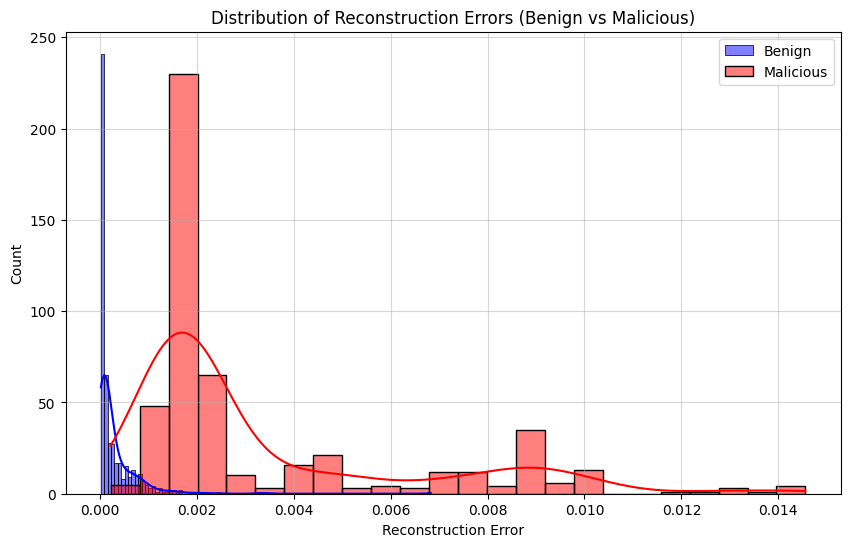

In [ ]:
if 'benign_errors' in locals() and 'malicious_errors' in locals():

    # Calculate Variance
    if benign_errors:
        benign_variance = np.var(benign_errors)
        print("\n--- Benign File Reconstruction Errors Variance ---")
        print(f"  Variance: {benign_variance:.6f}")
    else:
        print("\nNo benign errors data available to calculate variance.")

    if malicious_errors:
        malicious_variance = np.var(malicious_errors)
        print("\n--- Malicious File Reconstruction Errors Variance ---")
        print(f"  Variance: {malicious_variance:.6f}")
    else:
        print("\nNo malicious errors data available to calculate variance.")


    # Visualize Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(benign_errors, kde=True, color='blue', label='Benign', stat='count', common_norm=False)
    sns.histplot(malicious_errors, kde=True, color='red', label='Malicious', stat='count', common_norm=False)

    plt.title('Distribution of Reconstruction Errors (Benign vs Malicious)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

## 임계값 설정

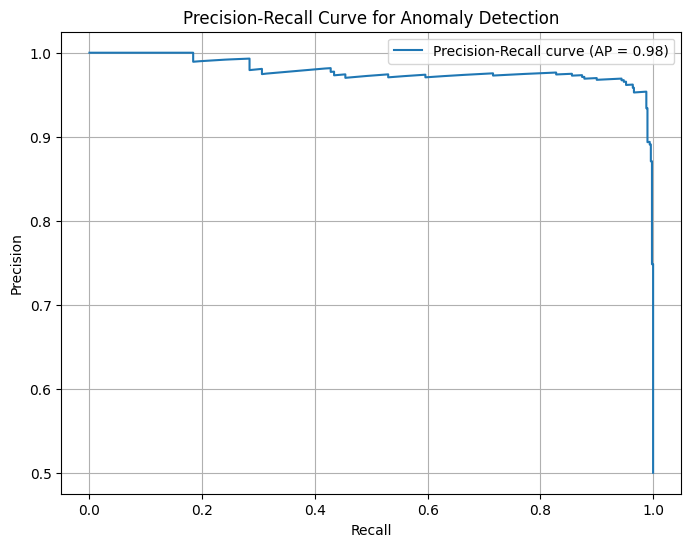

Average Precision (AP) Score: 0.9791

Threshold to achieve ~0.90 Recall:
  Threshold: 0.000022
  Corresponding Precision: 0.500000

Threshold to achieve ~0.80 Precision:
  Threshold: 0.000365
  Corresponding Recall: 0.998000


In [ ]:
if 'benign_errors' in locals() and 'malicious_errors' in locals():
    all_errors = np.array(benign_errors + malicious_errors)
    all_labels = np.array([0] * len(benign_errors) + [1] * len(malicious_errors))

    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(all_labels, all_errors)

    # Calculate Average Precision (AP) score
    avg_precision = average_precision_score(all_labels, all_errors)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Anomaly Detection')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Average Precision (AP) Score: {avg_precision:.4f}")

    target_recall = 0.9
    if target_recall <= np.max(recall):
        idx = np.argmin(np.abs(recall - target_recall))

        # recall >= target_recall 인 임계값 찾기
        valid_threshold_indices = np.where(recall >= target_recall)[0]
        if valid_threshold_indices.size > 0:
            threshold_at_target_recall = thresholds[valid_threshold_indices[0]]
            precision_at_target_recall = precision[valid_threshold_indices[0]]
            print(f"\nThreshold to achieve ~{target_recall:.2f} Recall:")
            print(f"  Threshold: {threshold_at_target_recall:.6f}")
            print(f"  Corresponding Precision: {precision_at_target_recall:.6f}")
        else:
            print(f"\nCannot achieve a recall of {target_recall:.2f} with the current model.")

    # precision이 0.8일떄
    target_precision = 0.8
    if target_precision <= np.max(precision):
         # Find the index where precision is closest to the target
        idx = np.argmin(np.abs(precision - target_precision))
         # Threshold corresponding to this point
        if idx < len(thresholds): # Ensure index is within bounds
            threshold_at_target_precision = thresholds[idx]
            recall_at_target_precision = recall[idx]
            print(f"\nThreshold to achieve ~{target_precision:.2f} Precision:")
            print(f"  Threshold: {threshold_at_target_precision:.6f}")
            print(f"  Corresponding Recall: {recall_at_target_precision:.6f}")
        else:
             print(f"\nCannot achieve a precision of {target_precision:.2f} with the current model.")
    else:
        print(f"\nCannot achieve a precision of {target_precision:.2f} with the current model.")

else:
    print("Error: Reconstruction error data (benign_errors, malicious_errors) not found.")
    print("Please run the error calculation cell first.")

단순히 recall(민감도)만 중시했을 때의 결과

Using anomaly detection threshold: 0.000022

--- Evaluation Metrics ---
Accuracy:  0.5010
Precision: 0.5005
Recall:    1.0000
F1-Score:  0.6671


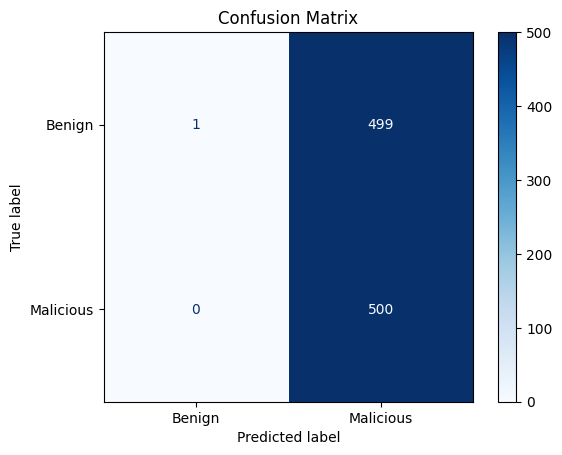

In [ ]:
if 'benign_errors' in locals() and 'malicious_errors' in locals():

    all_errors = np.array(benign_errors + malicious_errors)
    all_true_labels = np.array([0] * len(benign_errors) + [1] * len(malicious_errors))

    anomaly_threshold = 0.000022 # recall 최대인 임계값

    print(f"Using anomaly detection threshold: {anomaly_threshold:.6f}")

    all_predicted_labels = (all_errors > anomaly_threshold).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    precision = precision_score(all_true_labels, all_predicted_labels)
    recall = recall_score(all_true_labels, all_predicted_labels)
    f1 = f1_score(all_true_labels, all_predicted_labels)

    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Display Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()


else:
    print("Error: Reconstruction error data (benign_errors, malicious_errors) not found.")
    print("Please run the error calculation cell (3f96ced3) first to generate the error data.")

precision과 recall 그 어딘가의 합의점...

Using anomaly detection threshold: 0.000365

--- Evaluation Metrics ---
Accuracy:  0.8740
Precision: 0.7997
Recall:    0.9980
F1-Score:  0.8879


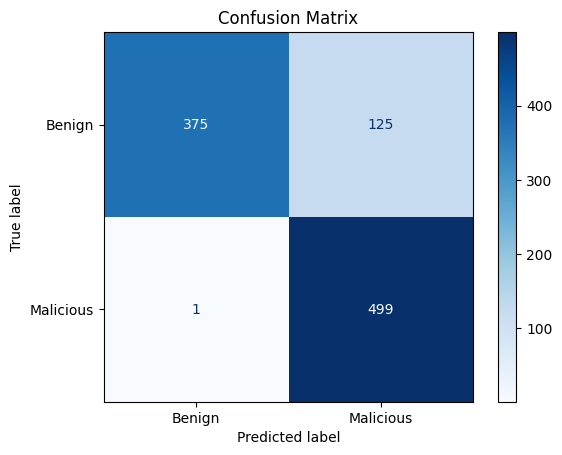

In [ ]:
if 'benign_errors' in locals() and 'malicious_errors' in locals():

    all_errors = np.array(benign_errors + malicious_errors)
    all_true_labels = np.array([0] * len(benign_errors) + [1] * len(malicious_errors))

    anomaly_threshold = 0.000365 # precision 0.8 이상인 임계값

    print(f"Using anomaly detection threshold: {anomaly_threshold:.6f}")

    all_predicted_labels = (all_errors > anomaly_threshold).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    precision = precision_score(all_true_labels, all_predicted_labels)
    recall = recall_score(all_true_labels, all_predicted_labels)
    f1 = f1_score(all_true_labels, all_predicted_labels)

    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Display Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()


else:
    print("Error: Reconstruction error data (benign_errors, malicious_errors) not found.")
    print("Please run the error calculation cell (3f96ced3) first to generate the error data.")

### 모델 저장

In [ ]:
save_dir = os.path.join(colab_path, "model")
save_path = os.path.join(save_dir, "model_gnn_7000.pt")

os.makedirs(save_dir, exist_ok=True)

if 'model' in locals() and model is not None:
    try:
        # 주석처리함
        #torch.save(model.state_dict(), save_path)
        print(f"GNN model successfully saved to {save_path}")
    except Exception as e:
        print(f"Error saving GNN model: {e}")
else:
    print("Model object not found. Cannot save.")

GNN model successfully saved to /content/drive/MyDrive/haksul/notebook/model/model_gnn_7000.pt


## 잠재공간 기준 임계값

Extracting latent representations from sampled files...


Extracting Latent Space:   0%|          | 0/1000 [00:00<?, ?it/s]

Latent space dimension: 32
Applying t-SNE for dimensionality reduction to 2D...


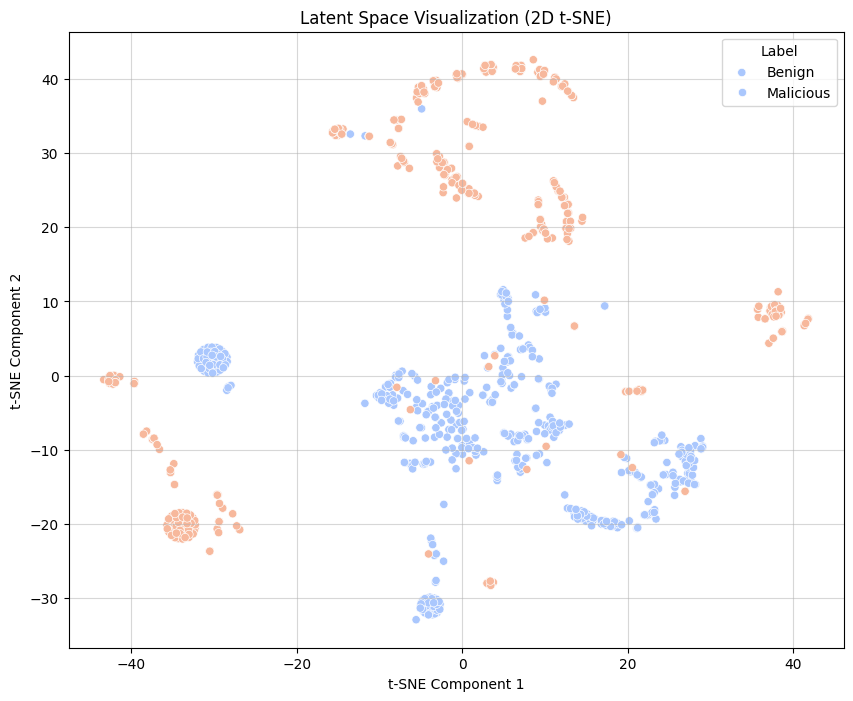

In [ ]:
if 'model' not in locals() or model is None:
    print("Error: Model object not found. Please run the model loading cell first.")
elif 'df' not in locals() or 'pdfdata_path' not in locals() or 'all_possible_types' not in locals():
     print("Error: Data or necessary variables (df, pdfdata_path, all_possible_types) not found. Please run initial data loading and preprocessing cells.")
else:
    try:
        df_benign_sample = df_benign.tail(500)
        df_malicious_sample = df[df['label'] == 1].sample(500, random_state=42)
        sampled_files = pd.concat([df_benign_sample, df_malicious_sample])
    except ValueError as e:
         print(f"Warning: Could not sample 500 files for both classes. Using available files. Error: {e}")
         benign_count = min(500, len(df[df['label'] == 0]))
         malicious_count = min(500, len(df[df['label'] == 1]))
         df_benign_sample = df[df['label'] == 0].sample(benign_count, random_state=42)
         df_malicious_sample = df[df['label'] == 1].sample(malicious_count, random_state=42)
         sampled_files = pd.concat([df_benign_sample, df_malicious_sample])
         print(f"Using {len(df_benign_sample)} benign and {len(df_malicious_sample)} malicious files for visualization.")


    latent_representations = []
    true_labels = []

    print("Extracting latent representations from sampled files...")

    from tqdm.notebook import tqdm

    model.eval()

    # Process sampled files to get latent representations
    for filename, row in tqdm(sampled_files.iterrows(), total=len(sampled_files), desc="Extracting Latent Space"):
        pdf_path = os.path.join(pdfdata_path, filename)
        label = row['label']

        try:
            parsed_objects = parse_pdf_with_pdfparser(pdf_path)
            if parsed_objects:
                graph = objects_to_graph(parsed_objects, all_possible_types)

                # Ensure graph feature dimension matches model input
                if graph.x.size(1) != model.conv1.in_channels:
                    print(f"Warning: Feature dimension mismatch for {filename}. Expected {model.conv1.in_channels}, got {graph.x.size(1)}. Skipping.")
                    continue

                # Perform inference to get graph representation (latent space)
                with torch.no_grad():
                    single_graph_loader = DataLoader([graph], batch_size=1)
                    for batch in single_graph_loader:
                        # Ensure batch is on the correct device if model is on GPU
                        # batch = batch.to(device) # Uncomment if using GPU
                        graph_representation, _ = model(batch) # Get the graph representation

                        latent_representations.append(graph_representation.squeeze().cpu().numpy()) # Remove batch dimension and move to CPU
                        true_labels.append(label)

        except Exception as e:
            print(f"  Error processing {filename}: {e}. Skipping.")

    if not latent_representations:
         print("No latent representations were extracted. Cannot visualize.")
    else:
        latent_representations = np.array(latent_representations)
        true_labels = np.array(true_labels)

        # --- Dimensionality Reduction (if necessary) ---
        # If the latent space dimension (model.conv2.out_channels after pooling) > 2 or 3
        latent_dim = latent_representations.shape[1]
        print(f"Latent space dimension: {latent_dim}")

        if latent_dim > 2:
            print("Applying t-SNE for dimensionality reduction to 2D...")
            try:
                tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='random', perplexity=30)
                if latent_representations.shape[0] > 3 * tsne.perplexity:
                    latent_2d = tsne.fit_transform(latent_representations)
                else:
                    print(f"Warning: Not enough samples ({latent_representations.shape[0]}) for t-SNE perplexity {tsne.perplexity}. Skipping t-SNE.")
                    latent_2d = latent_representations # Skip reduction if not enough data
            except Exception as e:
                print(f"Error during t-SNE: {e}")
                latent_2d = latent_representations # Fallback to original if t-SNE fails
                if latent_2d.shape[1] > 2:
                     print("Error: t-SNE failed and latent dimension is > 2. Cannot plot in 2D.")
                     latent_2d = None # Cannot plot if still > 2D and t-SNE failed

        else: # Latent dimension is already 2 or less
            latent_2d = latent_representations


        # --- Visualization ---
        if latent_2d is not None and latent_2d.shape[1] == 2:
            plt.figure(figsize=(10, 8))

            # Scatter plot colored by true label
            sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=true_labels, palette='coolwarm', legend='full')

            plt.title('Latent Space Visualization (2D t-SNE)')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.legend(title='Label', loc='best', labels=['Benign', 'Malicious']) # Add labels for legend
            plt.grid(True, alpha=0.5)
            plt.show()
        elif latent_2d is not None and latent_2d.shape[1] == 3:
             print("Latent space is 3D. 3D visualization is not directly supported in standard matplotlib scatter plots in this way.")
             print("You can use libraries like plotly or matplotlib's 3d plotting capabilities manually.")
        else:
             print("Latent space dimensionality not suitable for 2D visualization.")

reconstruction error 기준이 아니라 latent space에서 거리를 기준으로 판별했을 때


-> 오히려 더 안좋아짐...

Extracting latent representations and calculating distances...


Extracting Benign Latent Space:   0%|          | 0/500 [00:00<?, ?it/s]

Calculated benign centroid in latent space.
Calculating latent distances for sampled files...


Calculating Latent Distances:   0%|          | 0/1000 [00:00<?, ?it/s]


Determined anomaly threshold based on 95th percentile of benign distances: 0.386218

--- Evaluation Metrics (Latent Distance Threshold) ---
Accuracy:  0.6050
Precision: 0.9134
Recall:    0.2320
F1-Score:  0.3700


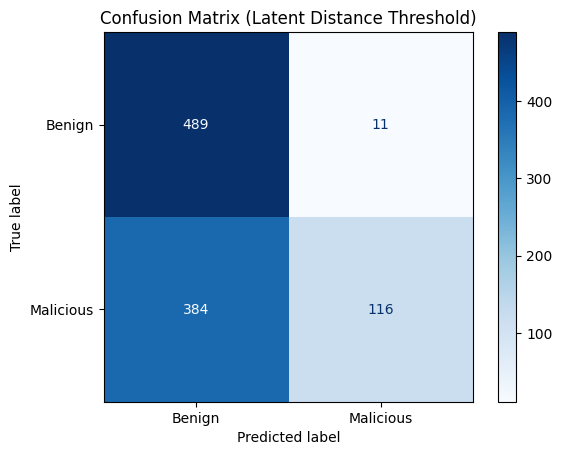

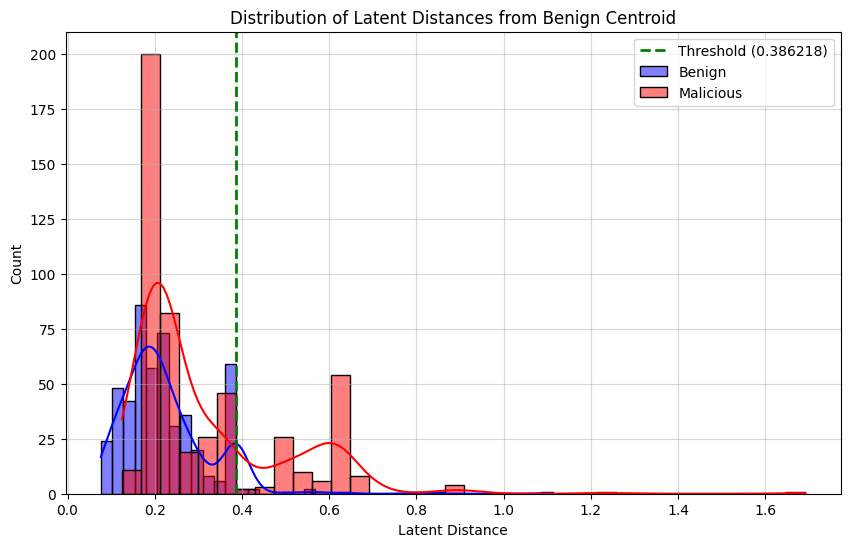

In [ ]:
from scipy.spatial.distance import euclidean # Import Euclidean distance

if 'model' not in locals() or model is None:
    print("Error: Model object not found. Please run the model loading cell (2Q0HZXfQE0zK) first.")
elif 'df' not in locals() or 'pdfdata_path' not in locals() or 'all_possible_types' not in locals():
     print("Error: Data or necessary variables (df, pdfdata_path, all_possible_types) not found. Please run initial data loading and preprocessing cells.")
else:
    # --- Prepare Data for Latent Space Distance Calculation ---

    # Use the same sampled files as in the latent space visualization (cell L_fk8xaFI_Dd)
    # This ensures the threshold is calculated based on the same data used for visualization
    try:
        # Sample 500 benign and 500 malicious files (adjust sample size if needed)
        # Ensure consistent sampling with evaluation if comparing results
        df_benign_sample = df_benign.tail(500)
        df_malicious_sample = df[df['label'] == 1].sample(500, random_state=42)
        sampled_files = pd.concat([df_benign_sample, df_malicious_sample])
    except ValueError as e:
         print(f"Warning: Could not sample 500 files for both classes. Using available files. Error: {e}")
         # Fallback to sampling available data if 500 is not possible
         benign_count = min(500, len(df[df['label'] == 0]))
         malicious_count = min(500, len(df[df['label'] == 1]))
         df_benign_sample = df[df['label'] == 0].sample(benign_count, random_state=42)
         df_malicious_sample = df[df['label'] == 1].sample(malicious_count, random_state=42)
         sampled_files = pd.concat([df_benign_sample, df_malicious_sample])
         print(f"Using {len(df_benign_sample)} benign and {len(df_malicious_sample)} malicious files for threshold calculation.")


    latent_distances = []
    true_labels = []
    benign_latent_representations = [] # Store benign latent reps to find the centroid

    print("Extracting latent representations and calculating distances...")

    # Use tqdm for progress bar
    from tqdm.notebook import tqdm

    model.eval() # Set model to evaluation mode

    # Process sampled benign files to find the centroid in the latent space
    for filename, row in tqdm(df_benign_sample.iterrows(), total=len(df_benign_sample), desc="Extracting Benign Latent Space"):
        pdf_path = os.path.join(pdfdata_path, filename)
        try:
            parsed_objects = parse_pdf_with_pdfparser(pdf_path)
            if parsed_objects:
                graph = objects_to_graph(parsed_objects, all_possible_types)

                # Ensure graph feature dimension matches model input
                if graph.x.size(1) != model.conv1.in_channels:
                    print(f"Warning: Feature dimension mismatch for {filename}. Expected {model.conv1.in_channels}, got {graph.x.size(1)}. Skipping.")
                    continue

                # Perform inference to get graph representation (latent space)
                with torch.no_grad():
                    single_graph_loader = DataLoader([graph], batch_size=1)
                    for batch in single_graph_loader:
                        graph_representation, _ = model(batch)
                        benign_latent_representations.append(graph_representation.squeeze().cpu().numpy())
            else:
                pass # Suppress for cleaner output with tqdm
        except Exception as e:
            print(f"  Error processing {filename}: {e}. Skipping.")

    if not benign_latent_representations:
        print("Error: No benign latent representations extracted. Cannot calculate centroid.")
    else:
        # Calculate the centroid of the benign latent representations
        benign_centroid = np.mean(benign_latent_representations, axis=0)
        print(f"Calculated benign centroid in latent space.")

        # Now calculate the distance of each sampled file from the benign centroid
        print("Calculating latent distances for sampled files...")
        for filename, row in tqdm(sampled_files.iterrows(), total=len(sampled_files), desc="Calculating Latent Distances"):
            pdf_path = os.path.join(pdfdata_path, filename)
            label = row['label']

            try:
                parsed_objects = parse_pdf_with_pdfparser(pdf_path)
                if parsed_objects:
                    graph = objects_to_graph(parsed_objects, all_possible_types)

                    # Ensure graph feature dimension matches model input
                    if graph.x.size(1) != model.conv1.in_channels:
                        print(f"Warning: Feature dimension mismatch for {filename}. Expected {model.conv1.in_channels}, got {graph.x.size(1)}. Skipping.")
                        continue

                    # Perform inference to get graph representation (latent space)
                    with torch.no_grad():
                        single_graph_loader = DataLoader([graph], batch_size=1)
                        for batch in single_graph_loader:
                            graph_representation, _ = model(batch)
                            latent_rep = graph_representation.squeeze().cpu().numpy()

                            # Calculate Euclidean distance from the benign centroid
                            distance = euclidean(latent_rep, benign_centroid)

                            latent_distances.append(distance)
                            true_labels.append(label)
                else:
                    pass # Suppress for cleaner output with tqdm
            except Exception as e:
                print(f"  Error processing {filename}: {e}. Skipping.")


        if not latent_distances:
            print("No latent distances were calculated. Cannot proceed with thresholding.")
        else:
            latent_distances = np.array(latent_distances)
            true_labels = np.array(true_labels)

            # Separate distances for benign and malicious files
            benign_distances = latent_distances[true_labels == 0]
            malicious_distances = latent_distances[true_labels == 1]


            # --- Determine Threshold based on Benign Distances ---
            # A common approach for one-class learning is to set the threshold
            # based on the distribution of scores (distances) for the normal class (benign).
            # For example, using a percentile of benign distances.

            # Example: Set threshold as the 95th percentile of benign distances
            if benign_distances.size > 0:
                anomaly_threshold = np.percentile(benign_distances, 95) # 95th percentile
                print(f"\nDetermined anomaly threshold based on 95th percentile of benign distances: {anomaly_threshold:.6f}")

                # --- Evaluate Performance using Latent Distance Threshold ---

                # Apply the threshold to the latent distances to get predicted labels
                # If distance > threshold, predict as malicious (1)
                # If distance <= threshold, predict as benign (0)
                predicted_labels = (latent_distances > anomaly_threshold).astype(int)

                # Calculate evaluation metrics
                accuracy = accuracy_score(true_labels, predicted_labels)
                precision = precision_score(true_labels, predicted_labels)
                recall = recall_score(true_labels, predicted_labels)
                f1 = f1_score(true_labels, predicted_labels)

                print("\n--- Evaluation Metrics (Latent Distance Threshold) ---")
                print(f"Accuracy:  {accuracy:.4f}")
                print(f"Precision: {precision:.4f}")
                print(f"Recall:    {recall:.4f}")
                print(f"F1-Score:  {f1:.4f}")

                # Display Confusion Matrix
                cm = confusion_matrix(true_labels, predicted_labels)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
                disp.plot(cmap='Blues')
                plt.title('Confusion Matrix (Latent Distance Threshold)')
                plt.show()

                # Visualize Distribution of Latent Distances
                plt.figure(figsize=(10, 6))
                sns.histplot(benign_distances, kde=True, color='blue', label='Benign', stat='count', common_norm=False)
                sns.histplot(malicious_distances, kde=True, color='red', label='Malicious', stat='count', common_norm=False)
                plt.axvline(anomaly_threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold ({anomaly_threshold:.6f})')

                plt.title('Distribution of Latent Distances from Benign Centroid')
                plt.xlabel('Latent Distance')
                plt.ylabel('Count')
                plt.legend()
                plt.grid(True, alpha=0.5)
                plt.show()


            else:
                print("No benign distances calculated. Cannot determine a threshold.")

# GNN - new

## GNN 학습

In [ ]:
# One-Class GNN 모델 정의 및 학습 (Early Stopping 및 Edge Reconstruction 추가)

# 저장된 그래프 데이터 로드 (이전 셀에서 생성된 graph_list를 사용)
if 'graph_list' not in locals() or not graph_list:
    load_path = os.path.join(colab_path, "data_feature", "GNN_list_batch_32_benign_7000.pt") # Use the corrected file name
    try:
        if os.path.exists(load_path):
            print(f"Loading graph_list from {load_path}")
            graph_list = torch.load(load_path)
            print(f"Successfully loaded {len(graph_list)} graphs.")
        else:
            print(f"Error: Saved graph data not found at {load_path}")
            print("Please run the data generation cell (e2728c51) first to create the graph data.")
            graph_list = [] # Ensure graph_list is empty if loading fails

    except Exception as e:
        print(f"Error loading graph_list: {e}")
        print("Please ensure the data generation and saving steps were successful.")
        graph_list = [] # Ensure graph_list is empty if loading fails


if graph_list:
    train_graphs = graph_list

    # 데이터 로더 생성
    loader = DataLoader(train_graphs, batch_size=32, shuffle=True)

    # One-Class GNN Model Definition (Autoencoder-like with Edge Reconstruction)
    class OneClassPDFGNN(nn.Module):
        def __init__(self, in_channels, hidden=64): # Increased hidden size
            super().__init__()
            # Encoder
            self.conv1 = GCNConv(in_channels, hidden)
            self.conv2 = GCNConv(hidden, hidden)
            # Decoder (node-level reconstruction)
            self.decoder_node_lin1 = nn.Linear(hidden, hidden)
            self.decoder_node_lin2 = nn.Linear(hidden, in_channels)  # 복원할 feature 차원

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch

            # Encoder
            x = F.relu(self.conv1(x, edge_index))
            node_representation = F.relu(self.conv2(x, edge_index)) # Node representations in latent space

            # Edge Decoder: 엣지 단위 복원 (Inner Product)
            row, col = edge_index
            # Calculate inner product for existing edges
            edge_scores = torch.sum(node_representation[row] * node_representation[col], dim=1)

            return reconstructed_x, edge_scores, node_representation # Return node_representation for potential future use


    # Model Initialization
    in_channels = graph_list[0].x.size(1)
    model = OneClassPDFGNN(in_channels=in_channels, hidden=64) # Use increased hidden size
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Loss Functions
    criterion_node = nn.MSELoss() # MSE for node feature reconstruction

    criterion_edge = nn.BCEWithLogitsLoss()

    # Early Stopping Parameters
    patience = 10 # How many epochs to wait after last improvement
    min_delta = 0.001 # Minimum change to be considered an improvement
    best_loss = None
    epochs_no_improve = 0

    # Store loss values for plotting
    train_losses = []
    train_node_losses = []
    train_edge_losses = []


    # Training Loop
    num_epochs = 200 # Increased potential epochs due to early stopping
    print(f"Starting training for up to {num_epochs} epochs with Early Stopping (Patience: {patience})...")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_node_loss = 0
        total_edge_loss = 0
        num_batches = 0

        for batch in loader:
            optimizer.zero_grad()
            reconstructed_x, edge_scores, _ = model(batch)

            # Node Reconstruction Loss (MSE) - Apply loss function to the entire batch
            # batch.x contains the original features for all nodes in the batch, flattened
            node_loss = criterion_node(reconstructed_x, batch.x)

            # Edge Reconstruction Loss (BCEWithLogitsLoss for existing edges)
            # Target for existing edges is 1
            edge_target = torch.ones_like(edge_scores)
            edge_loss = criterion_edge(edge_scores, edge_target)


            # Total Loss (Combine node and edge loss)
            # You might want to weight these losses differently
            loss = node_loss + edge_loss # Simple sum


            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_node_loss += node_loss.item()
            total_edge_loss += edge_loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        avg_node_loss = total_node_loss / num_batches if num_batches > 0 else 0
        avg_edge_loss = total_edge_loss / num_batches if num_batches > 0 else 0

        print(f"Epoch {epoch+1}/{num_epochs}: Total Loss={avg_loss:.4f}, Node Loss={avg_node_loss:.4f}, Edge Loss={avg_edge_loss:.4f}")

        # Store average loss for this epoch
        train_losses.append(avg_loss)
        train_node_losses.append(avg_node_loss)
        train_edge_losses.append(avg_edge_loss)


        # Early Stopping Check
        if best_loss is None or avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            epochs_no_improve = 0
            # Optionally save the best model state here
            # torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break # Stop training loop

    print("Training finished.")

Starting training for up to 200 epochs with Early Stopping (Patience: 10)...
Epoch 1/200: Total Loss=0.0547, Node Loss=0.0087, Edge Loss=0.0460
Epoch 2/200: Total Loss=0.0042, Node Loss=0.0041, Edge Loss=0.0001
Epoch 3/200: Total Loss=0.0032, Node Loss=0.0032, Edge Loss=0.0000
Epoch 4/200: Total Loss=0.0027, Node Loss=0.0027, Edge Loss=0.0000
Epoch 5/200: Total Loss=0.0023, Node Loss=0.0023, Edge Loss=0.0000
Epoch 6/200: Total Loss=0.0020, Node Loss=0.0020, Edge Loss=0.0000
Epoch 7/200: Total Loss=0.0018, Node Loss=0.0018, Edge Loss=0.0000
Epoch 8/200: Total Loss=0.0016, Node Loss=0.0016, Edge Loss=0.0000
Epoch 9/200: Total Loss=0.0015, Node Loss=0.0014, Edge Loss=0.0000
Epoch 10/200: Total Loss=0.0013, Node Loss=0.0013, Edge Loss=0.0000
Epoch 11/200: Total Loss=0.0012, Node Loss=0.0012, Edge Loss=0.0000
Epoch 12/200: Total Loss=0.0011, Node Loss=0.0011, Edge Loss=0.0000
Epoch 13/200: Total Loss=0.0011, Node Loss=0.0011, Edge Loss=0.0000
Epoch 14/200: Total Loss=0.0010, Node Loss=0.001

## GNN 성능 검증

In [ ]:
# Define the One-Class GNN Model Architecture (needs to match the trained model)
# This class definition is necessary to create an instance of the model to load weights into.
# Ensure this architecture matches the one used in cell 5IiyJ9ix4UIV (GNN-new)
class OneClassPDFGNN(nn.Module):
    def __init__(self, in_channels, hidden=64): # Increased hidden size for GNN-new
        super().__init__()
        # Encoder
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        # Decoder (node-level reconstruction)
        self.decoder_node_lin1 = nn.Linear(hidden, hidden)
        self.decoder_node_lin2 = nn.Linear(hidden, in_channels)  # 복원할 feature 차원

        # Decoder (edge-level reconstruction) - Using inner product as in training cell
        # No additional layers needed for inner product

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Encoder
        x = F.relu(self.conv1(x, edge_index))
        node_representation = F.relu(self.conv2(x, edge_index)) # Node representations in latent space

        # Node Decoder: 노드 단위 복원
        reconstructed_x = F.relu(self.decoder_node_lin1(node_representation))
        reconstructed_x = self.decoder_node_lin2(reconstructed_x)

        # Edge Decoder: 엣지 단위 복원 (Inner Product)
        # Compute pairwise scores for existing edges
        row, col = edge_index
        edge_scores = torch.sum(node_representation[row] * node_representation[col], dim=1)

        return reconstructed_x, edge_scores, node_representation # Return all three outputs


# Define the path to the saved graph_list and the NEW model
graph_list_path = os.path.join(colab_path, "data_feature", "GNN_list_batch_32_benign_7000.pt")
model_save_dir = os.path.join(colab_path, "model")
model_path = os.path.join(model_save_dir, "model_gnn_new.pt") # Use the NEW model file name

# Load the graph_list (needed to determine in_channels and for sampling benign graphs)
if os.path.exists(graph_list_path):
    try:
        print(f"Loading graph_list from {graph_list_path}")
        graph_list = torch.load(graph_list_path, weights_only=False)
        print(f"Successfully loaded {len(graph_list)} graphs.")

        # Determine the input channels from the loaded graph_list
        if graph_list:
            in_channels = graph_list[0].x.size(1)
            print(f"Determined input feature dimension from graph_list: {in_channels}")
        else:
            print("Warning: Loaded graph_list is empty.")
            in_channels = None

    except Exception as e:
        print(f"Error loading graph_list from {graph_list_path}: {e}")
        graph_list = None
        in_channels = None
else:
    print(f"Error: graph_list file not found at {graph_list_path}")
    print("Please run the data generation and saving steps (e2728c51 and 3c418701) first.")
    graph_list = None
    in_channels = None


# Load the trained model (GNN-new)
model = None # Initialize model to None
if in_channels is not None:
    # Instantiate the new model architecture
    model = OneClassPDFGNN(in_channels=in_channels, hidden=64) # Use hidden=64

    if os.path.exists(model_path):
        try:
            # Load the state dict from the saved NEW model file
            model.load_state_dict(torch.load(model_path))
            model.eval() # Set the model to evaluation mode
            print(f"Model successfully loaded from {model_path}")
        except Exception as e:
            print(f"Error loading model state dictionary from {model_path}: {e}")
            print("Please ensure the saved model file is not corrupted and matches the NEW model architecture (hidden=64).")
            model = None # Set model to None if loading fails
    else:
        print(f"Error: NEW Model file not found at {model_path}")
        print("Please run the NEW model training and saving steps (5IiyJ9ix4UIV and qmUEnaQe4UIX) first.")
        model = None # Set model to None if file not found
else:
    print("Model not initialized due to missing input channel information or empty graph_list.")


# --- Anomaly Detection Example (using Reconstruction Error) ---
# This part remains similar, but the model now calculates both node and edge scores.
# You might combine these scores for anomaly detection, or use them separately.
# For a simple example, let's still look at node reconstruction error as a primary indicator.
# A more advanced anomaly score could combine node and edge errors.

if model is not None and graph_list is not None:
    print("\n--- Anomaly Detection Example (using GNN-new) ---")
    model.eval() # Set model to evaluation mode

    # Sample a few benign graphs from the loaded graph_list
    if len(graph_list) > 0:
        sample_graphs = random.sample(graph_list, min(5, len(graph_list))) # Sample a few benign graphs
    else:
        sample_graphs = []
        print("Warning: graph_list is empty. Cannot sample benign graphs for example.")


    if sample_graphs:
        # Need the edge reconstruction loss criterion again for evaluation example
        criterion_edge = nn.BCEWithLogitsLoss() # Assuming target 1 for existing edges

        with torch.no_grad():
            print("Reconstruction errors and edge scores for sample benign graphs:")
            for i, graph in enumerate(sample_graphs):
                # Ensure graph is on the correct device if model is on GPU
                # graph = graph.to(device) # Uncomment if using GPU

                # Get outputs from the new model
                reconstructed_x, edge_scores, _ = model(graph)

                # Calculate node reconstruction error
                node_reconstruction_error = F.mse_loss(reconstructed_x, graph.x).item()

                # Calculate edge reconstruction error (using BCEWithLogitsLoss for existing edges)
                # Note: This calculates the loss assuming existing edges should have score 1.
                # A low error here means the model successfully assigned high scores to existing edges.
                if edge_scores.numel() > 0: # Check if there are any edges
                    edge_target = torch.ones_like(edge_scores)
                    edge_reconstruction_error = criterion_edge(edge_scores, edge_target).item()
                else:
                    edge_reconstruction_error = 0.0 # No edges, no edge error


                print(f"  Sample Benign Graph {i+1}: Node Error={node_reconstruction_error:.6f}, Edge BCE Loss={edge_reconstruction_error:.6f}")

        print("\nNote: To evaluate anomaly detection, you would compare these scores")
        print("of known benign graphs (trained on) with known malicious graphs (unseen during training).")
        print("Higher node reconstruction error or potentially different edge score patterns on unseen graphs suggest potential anomaly.")
        print("You could define an anomaly score combining node and edge metrics.")
    else:
        print("No sample graphs available to demonstrate anomaly detection example.")

else:
    print("Model and/or graph_list are not available. Cannot run anomaly detection example.")

Loading graph_list from /content/drive/MyDrive/haksul/notebook/data_feature/GNN_list_batch_32_benign_7000.pt
Successfully loaded 7000 graphs.
Determined input feature dimension from graph_list: 55
Model successfully loaded from /content/drive/MyDrive/haksul/notebook/model/model_gnn_new.pt

--- Anomaly Detection Example (using GNN-new) ---
Reconstruction errors and edge scores for sample benign graphs:
  Sample Benign Graph 1: Node Error=0.000400, Edge BCE Loss=0.000002
  Sample Benign Graph 2: Node Error=0.000503, Edge BCE Loss=0.000001
  Sample Benign Graph 3: Node Error=0.000398, Edge BCE Loss=0.000000
  Sample Benign Graph 4: Node Error=0.000474, Edge BCE Loss=0.000001
  Sample Benign Graph 5: Node Error=0.000310, Edge BCE Loss=0.000000

Note: To evaluate anomaly detection, you would compare these scores
of known benign graphs (trained on) with known malicious graphs (unseen during training).
Higher node reconstruction error or potentially different edge score patterns on unseen gra

### 모델 및 그래프 데이터 불러오기

In [ ]:
all_possible_types = [
  "3D", "3DLightingScheme", "3DRenderMode", "3DView",
  "A", "Action", "Annot", "Border", "Catalog", "ContentRegion",
  "EmbeddedFile", "Encoding", "ExtGState", "FileSpec", "Filespec",
  "Flow", "Font", "FontDescriptor", "Group", "Halftone",
  "JobTicketContents", "Layout", "MCR", "Mask", "MediaClip",
  "MediaPermissions", "Metadata", "OBJR", "OCG", "OCMD",
  "OPI", "ObjStm", "Outlines", "OutputIntent", "Page",
  "Pages", "Pattern", "RestoreTree", "Sig", "SigFieldLock",
  "StructElem", "StructTreeRoot", "Template", "Timespan", "TransformParams",
  "Unknown", "ViewerPreferences", "XObject", "XRef"
]

In [ ]:
# Define the path to the saved graph_list and model
graph_list_path = os.path.join(colab_path, "data_feature", "GNN_list_batch_32_benign_7000.pt")
model_save_dir = os.path.join(colab_path, "model")
model_path = os.path.join(model_save_dir, "model_gnn_new.pt") # Load the new model

# Load the graph_list
if os.path.exists(graph_list_path):
    try:
        print(f"Loading graph_list from {graph_list_path}")
        # Add weights_only=False to load the graph_list which contains non-tensor objects
        graph_list = torch.load(graph_list_path, weights_only=False)
        print(f"Successfully loaded {len(graph_list)} graphs.")

        # Determine the input channels from the loaded graph_list
        if graph_list:
            in_channels = graph_list[0].x.size(1)
            print(f"Determined input feature dimension from graph_list: {in_channels}")
        else:
            print("Warning: Loaded graph_list is empty.")
            in_channels = None

    except Exception as e:
        print(f"Error loading graph_list from {graph_list_path}: {e}")
        graph_list = None
        in_channels = None
else:
    print(f"Error: graph_list file not found at {graph_list_path}")
    print("Please run the data generation and saving steps (e2728c51 and 3c418701) first.")
    graph_list = None
    in_channels = None


# Define the One-Class GNN Model Architecture (needs to match the trained model)
# This class definition is necessary to create an instance of the model to load weights into.
# Ensure this architecture matches the one used in cell 5IiyJ9ix4UIV (GNN-new)
class OneClassPDFGNN(nn.Module):
    def __init__(self, in_channels, hidden=64): # Updated hidden size to 64
        super().__init__()
        # Encoder
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        # Decoder (node-level reconstruction) - Updated layer names
        self.decoder_node_lin1 = nn.Linear(hidden, hidden)
        self.decoder_node_lin2 = nn.Linear(hidden, in_channels)  # 복원할 feature 차원

        # Edge Decoder (using inner product) - Added for consistency with new model
        # This part is needed even if not directly used for the first anomaly score calculation
        # because the saved model state_dict will contain weights for it.
        # No additional layers needed for inner product

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Encoder
        x = F.relu(self.conv1(x, edge_index))
        node_representation = F.relu(self.conv2(x, edge_index)) # Node representations in latent space

        # Node Decoder: 노드 단위 복원 - Updated layer names
        reconstructed_x = F.relu(self.decoder_node_lin1(node_representation))
        reconstructed_x = self.decoder_node_lin2(reconstructed_x)

        # Edge Decoder: 엣지 단위 복원 (Inner Product) - Added for consistency
        row, col = edge_index
        edge_scores = torch.sum(node_representation[row] * node_representation[col], dim=1)

        return reconstructed_x, edge_scores, node_representation # Return all three outputs


# Load the trained model
model = None # Initialize model to None
if in_channels is not None:
    # Instantiate the new model architecture with hidden=64
    model = OneClassPDFGNN(in_channels=in_channels, hidden=64)

    if os.path.exists(model_path):
        try:
            # Load the state dict from the saved NEW model file
            # The strict=False flag can be helpful if the saved state_dict
            # has extra keys (e.g., optimizer state), but ideally the architecture
            # should match exactly. Let's try without strict=False first.
            model.load_state_dict(torch.load(model_path))
            model.eval() # Set the model to evaluation mode
            print(f"Model successfully loaded from {model_path}")
        except Exception as e:
            print(f"Error loading model state dictionary from {model_path}: {e}")
            print("Please ensure the saved model file is not corrupted and matches the NEW model architecture (hidden=64, and correct decoder layer names).")
            model = None # Set model to None if loading fails
    else:
        print(f"Error: NEW Model file not found at {model_path}")
        print("Please run the NEW model training and saving steps (5IiyJ9ix4UIV and qmUEnaQe4UIX) first.")
        model = None # Set model to None if file not found
else:
    print("Model not initialized due to missing input channel information or empty graph_list.")

Loading graph_list from /content/drive/MyDrive/haksul/notebook/data_feature/GNN_list_batch_32_benign_7000.pt
Successfully loaded 7000 graphs.
Determined input feature dimension from graph_list: 55
Model successfully loaded from /content/drive/MyDrive/haksul/notebook/model/model_gnn_new.pt


악성에 대해 score 계산

In [ ]:
# Define the path to the saved model
save_dir = os.path.join(colab_path, "model")
model_path = os.path.join(save_dir, "model_gnn_new.pt")

# Check if the model file exists and the model object exists
# Removed the check for model object existence here as it's expected to be loaded by a previous cell
if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}")
# Added a check to ensure 'model' is in the local scope and not None
elif 'model' not in locals() or model is None:
     print("Error: Model object not found in the current environment. Please ensure the model loading cell (LZurxa7f4UIV) was run successfully.")
else:
    # Load the saved state dictionary into the existing model object
    try:
        model.load_state_dict(torch.load(model_path))
        model.eval() # Set the model to evaluation mode
        print("Model loaded successfully.")

        # --- Anomaly Detection for a Sample Malicious File ---

        # Select a malicious file (label 1) from the df DataFrame
        df_malicious = df[df['label'] == 1]
        if not df_malicious.empty:
            # Randomly select one malicious file
            sample_malicious_filename = df_malicious.sample(1).index[0]
            sample_malicious_path = os.path.join(pdfdata_path, sample_malicious_filename)

            print(f"\nProcessing malicious file: {sample_malicious_filename}")

            # Preprocess the malicious file into a graph
            # We need the same 'all_possible_types' list used during training
            if 'all_possible_types' in locals():
                try:
                    parsed_objects = parse_pdf_with_pdfparser(sample_malicious_path)
                    if parsed_objects:
                        # Ensure objects_to_graph can handle the types in the new file
                        malicious_graph = objects_to_graph(parsed_objects, all_possible_types)

                        # Perform inference
                        with torch.no_grad():
                            single_malicious_loader = DataLoader([malicious_graph], batch_size=1)
                            for batch in single_malicious_loader:
                                # Ensure batch is on the correct device if model is on GPU
                                # batch = batch.to(device) # Uncomment if using GPU

                                # The model now outputs reconstructed_x, edge_scores, and node_representation
                                reconstructed_x, edge_scores, _ = model(batch)

                                # Calculate reconstruction error at the node level
                                reconstruction_error = F.mse_loss(reconstructed_x, batch.x).item()


                            print(f"  Reconstruction Error for {sample_malicious_filename}: {reconstruction_error:.4f}")

                    else:
                        print(f"  Warning: No objects parsed for {sample_malicious_filename}. Cannot perform anomaly detection.")
                except Exception as e:
                    print(f"  Error processing {sample_malicious_filename}: {e}")

            else:
                print("Error: 'all_possible_types' not found. Please re-run the graph data generation cell (e2728c51).")

        else:
            print("No malicious files (label 1) found in the df DataFrame.")

    except Exception as e:
        print(f"Error loading model state dictionary: {e}")
        print("Please ensure the saved model file is not corrupted and matches the model architecture.")

Model loaded successfully.

Processing malicious file: VirusShare_47ad22d19b8dbba8d524be49600b68a0
  Reconstruction Error for VirusShare_47ad22d19b8dbba8d524be49600b68a0: 0.0028


정상과 악성의 수치 계산

In [ ]:
df_benign_sample = df_benign.tail(500)

# Sample 100 malicious files randomly from the df DataFrame
df_malicious_sample = df[df['label'] == 1].sample(500, random_state=42) # Use random_state for reproducibility

# Combine the samples
sampled_files = pd.concat([df_benign_sample, df_malicious_sample])

# Ensure all_possible_types and the trained model are available from previous steps
if 'all_possible_types' not in locals():
    print("Error: 'all_possible_types' not found. Please re-run the graph data generation cell (e2728c51).")
elif 'model' not in locals() or model is None:
    print("Error: Model object not found. Please run the training cell (8c9ce9aa) and model loading cell (zA6SMdPGO8YI) first.")
# Removed the check for the robust parsing function

else:
    # Process sampled files and calculate reconstruction error
    model.eval() # Set model to evaluation mode
    benign_errors = []
    malicious_errors = []

    print("Processing sampled files and calculating reconstruction errors...")

    # Use tqdm for progress bar


    for filename, row in tqdm(sampled_files.iterrows(), total=len(sampled_files), desc="Calculating Errors"):
        pdf_path = os.path.join(pdfdata_path, filename)
        label = row['label']

        try:
            # Use the original parsing function
            parsed_objects = parse_pdf_with_pdfparser(pdf_path)
            if parsed_objects:
                # Ensure the graph has the correct feature dimension
                graph = objects_to_graph(parsed_objects, all_possible_types)

                # Check for feature dimension consistency with the trained model
                if graph.x.size(1) == model.conv1.in_channels: # Changed != to == to check for success case
                    # Perform inference
                    with torch.no_grad():
                        single_graph_loader = DataLoader([graph], batch_size=1)
                        for batch in single_graph_loader:
                            # Ensure batch is on the correct device if model is on GPU
                            # batch = batch.to(device) # Uncomment if using GPU

                            # The model outputs graph_representation and reconstructed_features
                            # The new model (gnn_new) also outputs edge_scores, which we can ignore for node error calculation
                            reconstructed_x, edge_scores, _ = model(batch)


                            # Calculate reconstruction error at the node level, consistent with training
                            # We compare the reconstructed features for each node with the original node features
                            node_reconstruction_error = F.mse_loss(reconstructed_x, batch.x)


                            if label == 0:
                                benign_errors.append(node_reconstruction_error.item())
                            else:
                                malicious_errors.append(node_reconstruction_error.item())


        except Exception as e:
            # This will catch errors from parsing or graph creation
            # Retain the error printing for debugging which files cause issues
            print(f"  Error processing {filename}: {e}. Skipping.")


    # Calculate statistics for benign errors
    if benign_errors:
        benign_mean_error = np.mean(benign_errors)
        benign_max_error = np.max(benign_errors)
        benign_min_error = np.min(benign_errors)
        print("\n--- Benign File Reconstruction Errors ---")
        print(f"  Processed {len(benign_errors)} benign files.")
        print(f"  Mean Error: {benign_mean_error:.6f}")
        print(f"  Max Error:  {benign_max_error:.6f}")
        print(f"  Min Error:  {benign_min_error:.6f}")
    else:
        print("\nNo benign files processed.")

    # Calculate statistics for malicious errors
    if malicious_errors:
        malicious_mean_error = np.mean(malicious_errors)
        malicious_max_error = np.max(malicious_errors)
        malicious_min_error = np.min(malicious_errors)
        print("\n--- Malicious File Reconstruction Errors ---")
        print(f"  Processed {len(malicious_errors)} malicious files.")
        print(f"  Mean Error: {malicious_mean_error:.6f}")
        print(f"  Max Error:  {malicious_max_error:.6f}")
        print(f"  Min Error:  {malicious_min_error:.6f}")
    else:
        print("\nNo malicious files processed.")

Processing sampled files and calculating reconstruction errors...


Calculating Errors:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Benign File Reconstruction Errors ---
  Processed 500 benign files.
  Mean Error: 0.000784
  Max Error:  0.010210
  Min Error:  0.000138

--- Malicious File Reconstruction Errors ---
  Processed 500 malicious files.
  Mean Error: 0.004633
  Max Error:  0.027800
  Min Error:  0.000893



--- Benign File Reconstruction Errors Variance ---
  Variance: 0.000001

--- Malicious File Reconstruction Errors Variance ---
  Variance: 0.000010


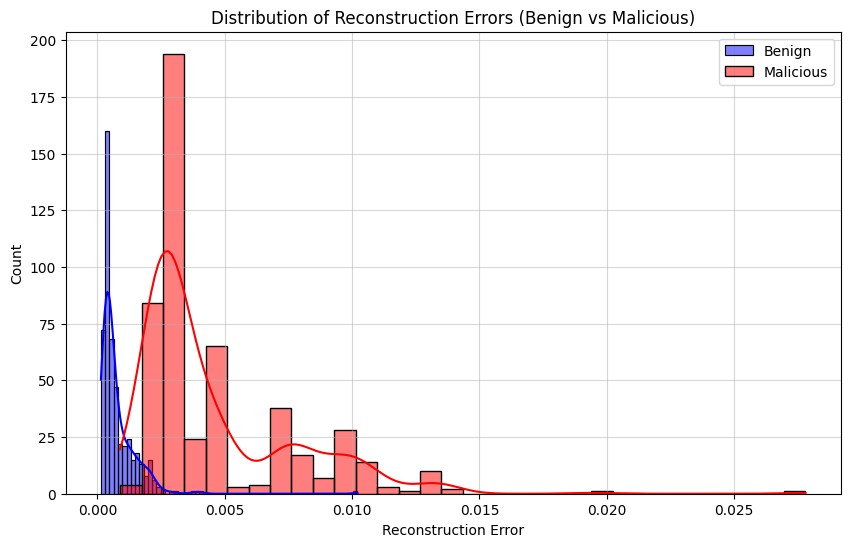

In [ ]:
if 'benign_errors' in locals() and 'malicious_errors' in locals():

    # Calculate Variance
    if benign_errors:
        benign_variance = np.var(benign_errors)
        print("\n--- Benign File Reconstruction Errors Variance ---")
        print(f"  Variance: {benign_variance:.6f}")
    else:
        print("\nNo benign errors data available to calculate variance.")

    if malicious_errors:
        malicious_variance = np.var(malicious_errors) # Corrected typo here
        print("\n--- Malicious File Reconstruction Errors Variance ---")
        print(f"  Variance: {malicious_variance:.6f}")
    else:
        print("\nNo malicious errors data available to calculate variance.")


    # Visualize Distribution
    plt.figure(figsize=(10, 6))
    # Change stat='density' to stat='count' to show sample counts on the y-axis
    sns.histplot(benign_errors, kde=True, color='blue', label='Benign', stat='count', common_norm=False)
    sns.histplot(malicious_errors, kde=True, color='red', label='Malicious', stat='count', common_norm=False)

    plt.title('Distribution of Reconstruction Errors (Benign vs Malicious)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count') # Update y-axis label
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

else:
    print("Error: Reconstruction error data (benign_errors, malicious_errors) not found.")
    print("Please run the previous cell (3f96ced3) to generate the error data first.")

## 임계값 설정

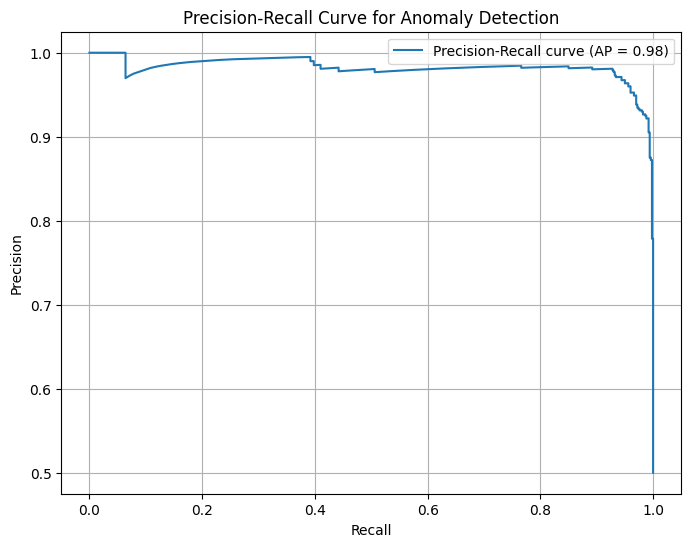

Average Precision (AP) Score: 0.9827

Threshold to achieve ~0.90 Recall:
  Threshold: 0.000138
  Corresponding Precision: 0.500000

Threshold to achieve ~0.80 Precision:
  Threshold: 0.001026
  Corresponding Recall: 0.998000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

# Ensure benign_errors and malicious_errors are available from previous steps
if 'benign_errors' in locals() and 'malicious_errors' in locals():

    # Combine errors and create corresponding labels (0 for benign, 1 for malicious)
    # In anomaly detection, benign samples are 'normal' (negative class) and malicious are 'anomalies' (positive class).
    # Reconstruction error is the 'score'. Higher score means more likely anomaly.
    # So, benign errors should correspond to label 0, malicious errors to label 1.
    all_errors = np.array(benign_errors + malicious_errors)
    all_labels = np.array([0] * len(benign_errors) + [1] * len(malicious_errors))

    # Calculate Precision-Recall curve
    # Note: In sklearn's precision_recall_curve, the positive class is assumed to be 1.
    # The 'probas_pred' should be scores where higher scores indicate the positive class (malicious).
    precision, recall, thresholds = precision_recall_curve(all_labels, all_errors)

    # Calculate Average Precision (AP) score
    avg_precision = average_precision_score(all_labels, all_errors)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Anomaly Detection')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Average Precision (AP) Score: {avg_precision:.4f}")

    target_recall = 0.9
    if target_recall <= np.max(recall):
        # Find the index where recall is closest to the target
        idx = np.argmin(np.abs(recall - target_recall))

        valid_threshold_indices = np.where(recall >= target_recall)[0]
        if valid_threshold_indices.size > 0:
            # Take the smallest threshold among those that achieve the target recall
            # Smallest threshold will correspond to highest precision at that recall level
            threshold_at_target_recall = thresholds[valid_threshold_indices[0]]
            precision_at_target_recall = precision[valid_threshold_indices[0]]
            print(f"\nThreshold to achieve ~{target_recall:.2f} Recall:")
            print(f"  Threshold: {threshold_at_target_recall:.6f}")
            print(f"  Corresponding Precision: {precision_at_target_recall:.6f}")
        else:
            print(f"\nCannot achieve a recall of {target_recall:.2f} with the current model.")

    # Example: Find threshold where precision is approximately 0.8
    target_precision = 0.8
    if target_precision <= np.max(precision):
         # Find the index where precision is closest to the target
        idx = np.argmin(np.abs(precision - target_precision))
         # Threshold corresponding to this point
        if idx < len(thresholds): # Ensure index is within bounds
            threshold_at_target_precision = thresholds[idx]
            recall_at_target_precision = recall[idx]
            print(f"\nThreshold to achieve ~{target_precision:.2f} Precision:")
            print(f"  Threshold: {threshold_at_target_precision:.6f}")
            print(f"  Corresponding Recall: {recall_at_target_precision:.6f}")
        else:
             print(f"\nCannot achieve a precision of {target_precision:.2f} with the current model.")
    else:
        print(f"\nCannot achieve a precision of {target_precision:.2f} with the current model.")

else:
    print("Error: Reconstruction error data (benign_errors, malicious_errors) not found.")
    print("Please run the error calculation cell (3f96ced3) first.")

단순히 recall(민감도)만 중시했을 때의 결과

Using anomaly detection threshold: 0.000138

--- Evaluation Metrics ---
Accuracy:  0.5000
Precision: 0.5000
Recall:    1.0000
F1-Score:  0.6667


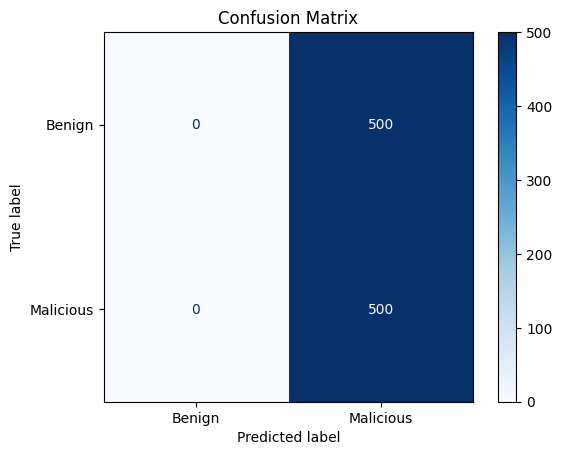

In [ ]:
if 'benign_errors' in locals() and 'malicious_errors' in locals():

    all_errors = np.array(benign_errors + malicious_errors)
    all_true_labels = np.array([0] * len(benign_errors) + [1] * len(malicious_errors))

    anomaly_threshold = 0.000138 # recall 최대 임계값

    print(f"Using anomaly detection threshold: {anomaly_threshold:.6f}")

    all_predicted_labels = (all_errors > anomaly_threshold).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    precision = precision_score(all_true_labels, all_predicted_labels)
    recall = recall_score(all_true_labels, all_predicted_labels)
    f1 = f1_score(all_true_labels, all_predicted_labels)

    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Display Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()


else:
    print("Error: Reconstruction error data (benign_errors, malicious_errors) not found.")
    print("Please run the error calculation cell (3f96ced3) first to generate the error data.")

precision과 recall 그 어딘가의 합의점...

Using anomaly detection threshold: 0.001026

--- Evaluation Metrics ---
Accuracy:  0.8750
Precision: 0.8010
Recall:    0.9980
F1-Score:  0.8887


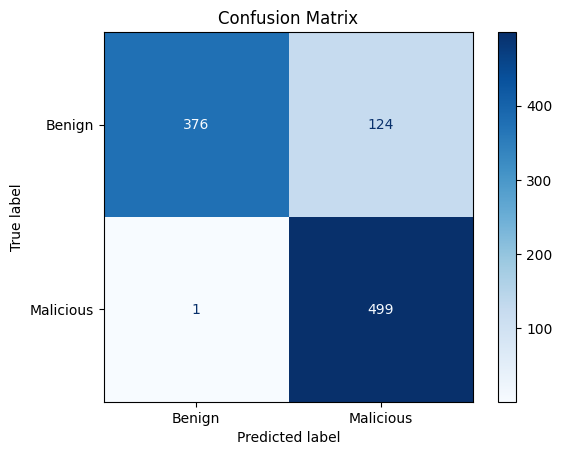

In [ ]:
if 'benign_errors' in locals() and 'malicious_errors' in locals():

    all_errors = np.array(benign_errors + malicious_errors)
    all_true_labels = np.array([0] * len(benign_errors) + [1] * len(malicious_errors))

    anomaly_threshold = 0.001026 # precision이 0.8 이상일 때의 임계값

    print(f"Using anomaly detection threshold: {anomaly_threshold:.6f}")

    all_predicted_labels = (all_errors > anomaly_threshold).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    precision = precision_score(all_true_labels, all_predicted_labels)
    recall = recall_score(all_true_labels, all_predicted_labels)
    f1 = f1_score(all_true_labels, all_predicted_labels)

    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Display Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()


else:
    print("Error: Reconstruction error data (benign_errors, malicious_errors) not found.")
    print("Please run the error calculation cell (3f96ced3) first to generate the error data.")

### 모델 저장

In [ ]:
import torch
import os

save_dir = os.path.join(colab_path, "model")
save_path = os.path.join(save_dir, "model_gnn_new.pt")

os.makedirs(save_dir, exist_ok=True)

if 'model' in locals() and model is not None:
    try:
        # 주석처리함
        #torch.save(model.state_dict(), save_path)
        print(f"GNN model successfully saved to {save_path}")
    except Exception as e:
        print(f"Error saving GNN model: {e}")
else:
    print("Model object not found. Cannot save.")

GNN model successfully saved to /content/drive/MyDrive/haksul/notebook/model/model_gnn_new.pt
